In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Dataset Definition
# class GaussianBumpDataset(Dataset):
#     def __init__(self, num_samples=1000, grid_size=28, sigma=1.0, holdout_center=False, only_holdout=False, heldout_range=[5,22], bump_encoding_width_multiplier=1):
#         self.num_samples = num_samples
#         self.grid_size = grid_size
#         self.sigma = sigma
#         self.holdout_center = holdout_center
#         self.only_holdout = only_holdout
#         self.data = []
#         self.targets = []

#         holdout_min = heldout_range[0]
#         holdout_max = heldout_range[1]

#         for _ in range(num_samples):
#             while True:
#                 x, y = np.random.randint(0, grid_size, size=2)
#                 if self.holdout_center and (holdout_min <= x <= holdout_max and holdout_min <= y <= holdout_max):
#                     continue
#                 if self.only_holdout and not (holdout_min <= x <= holdout_max and holdout_min <= y <= holdout_max):
#                     continue
#                 break
             
#             gaussian_x = np.exp(-((np.arange(grid_size) - x) ** 2) / (2 * bump_encoding_width_multiplier * sigma ** 2))
#             gaussian_y = np.exp(-((np.arange(grid_size) - y) ** 2) / (2 * bump_encoding_width_multiplier * sigma ** 2))

#             xv, yv = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
#             gaussian_image = 1.0 - np.exp(-((xv - x) ** 2 + (yv - y) ** 2) / (2 * sigma ** 2))

#             self.data.append(np.concatenate((gaussian_x, gaussian_y)))
#             self.targets.append(gaussian_image)

#     def __len__(self):
#         return self.num_samples

#     def __getitem__(self, idx):
#         return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32).unsqueeze(0)


import torch
from torch.utils.data import Dataset
import numpy as np

class GaussianBumpDatasetSquare(Dataset):
    def __init__(self, num_samples=1000, grid_size=28, sigma=1.0, holdout_center=True, 
                 only_holdout=False, heldout_range=[10,18], bump_encoding_width_multiplier=1):
        self.num_samples = num_samples
        self.grid_size = grid_size
        self.sigma = sigma
        self.holdout_center = holdout_center
        self.only_holdout = only_holdout
        self.bump_encoding_width_multiplier = bump_encoding_width_multiplier
        self.data = []
        self.targets = []
        
        lb, ub = heldout_range
        self.holdout_min = lb
        self.holdout_max = ub
        
        # Pre-compute the meshgrid for efficiency
        self.xv, self.yv = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
        
        # Generate all samples at once
        self._generate_samples()
    
    def _generate_samples(self):
        if self.only_holdout:
            # Generate points directly within the holdout range
            x = np.random.randint(self.holdout_min, self.holdout_max + 1, size=self.num_samples)
            y = np.random.randint(self.holdout_min, self.holdout_max + 1, size=self.num_samples)
        elif self.holdout_center:
            x = []
            y = []
            while len(x) < self.num_samples:
                # Generate a batch of points
                batch_size = min(self.num_samples * 2, 10000)  # Generate points in batches
                x_batch = np.random.randint(0, self.grid_size, size=batch_size)
                y_batch = np.random.randint(0, self.grid_size, size=batch_size)
                
                # Create mask for valid points (outside holdout region)
                valid_mask = ~((x_batch >= self.holdout_min) & (x_batch <= self.holdout_max) & 
                              (y_batch >= self.holdout_min) & (y_batch <= self.holdout_max))
                
                # Add valid points to our lists
                x.extend(x_batch[valid_mask])
                y.extend(y_batch[valid_mask])
            
            # Trim to exact size needed
            x = x[:self.num_samples]
            y = y[:self.num_samples]
            
            # Convert back to numpy arrays
            x = np.array(x)
            y = np.array(y)
        else:
            # Generate points anywhere in the grid
            x = np.random.randint(0, self.grid_size, size=self.num_samples)
            y = np.random.randint(0, self.grid_size, size=self.num_samples)
        
        # Generate Gaussian images
        for i in range(self.num_samples):
            gaussian_image = 1.0 - np.exp(-((self.xv - x[i])**2 + (self.yv - y[i])**2) / 
                                        (2 * self.sigma**2))
            gaussian_x = np.exp(-((np.arange(self.grid_size) - x[i]) ** 2) / (2 * self.bump_encoding_width_multiplier * self.sigma ** 2))
            gaussian_y = np.exp(-((np.arange(self.grid_size) - y[i]) ** 2) / (2 * self.bump_encoding_width_multiplier * self.sigma ** 2))
            self.data.append(np.concatenate((gaussian_x, gaussian_y)))
            self.targets.append(gaussian_image)

    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx], dtype=torch.float32), 
                torch.tensor(self.targets[idx], dtype=torch.float32).unsqueeze(0))
    
import torch
from torch.utils.data import Dataset
import numpy as np

class GaussianBumpDatasetCross(Dataset):
    def __init__(self, num_samples=1000, grid_size=28, sigma=1.0, holdout_cross=True, 
                 only_holdout=False, heldout_range=[11,17]):
        self.num_samples = num_samples
        self.grid_size = grid_size
        self.sigma = sigma
        self.holdout_cross = holdout_cross
        self.only_holdout = only_holdout
        self.data = []
        self.targets = []
        
        self.lower_bound, self.upper_bound = heldout_range
        
        # Pre-compute the meshgrid and coordinate arrays
        self.xv, self.yv = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
        self.coord_array = np.arange(grid_size)
        
        # Generate all samples at once
        self._generate_samples()
    
    def _is_in_cross(self, x, y):
        """Vectorized check for points in cross region"""
        return ((self.lower_bound <= x) & (x < self.upper_bound)) | \
               ((self.lower_bound <= y) & (y < self.upper_bound))
    
    def _generate_samples(self):
        if self.only_holdout:
            valid_points = []
            # Calculate the size of each arm of the cross
            cross_width = self.upper_bound - self.lower_bound
            total_cross_points = (2 * cross_width * self.grid_size) - (cross_width * cross_width)
            
            # Generate points for horizontal arm
            horiz_x = np.random.randint(self.lower_bound, self.upper_bound, 
                                      size=(self.num_samples * 2))
            horiz_y = np.random.randint(0, self.grid_size, size=(self.num_samples * 2))
            
            # Generate points for vertical arm
            vert_x = np.random.randint(0, self.grid_size, size=(self.num_samples * 2))
            vert_y = np.random.randint(self.lower_bound, self.upper_bound, 
                                     size=(self.num_samples * 2))
            
            # Combine and shuffle points
            all_x = np.concatenate([horiz_x, vert_x])
            all_y = np.concatenate([horiz_y, vert_y])
            
            # Remove duplicates in intersection
            points = np.column_stack((all_x, all_y))
            points = np.unique(points, axis=0)
            
            # Randomly select required number of points
            indices = np.random.choice(len(points), self.num_samples, replace=False)
            x = points[indices, 0]
            y = points[indices, 1]
            
        elif self.holdout_cross:
            x = []
            y = []
            while len(x) < self.num_samples:
                # Generate a batch of points
                batch_size = min(self.num_samples * 2, 10000)
                x_batch = np.random.randint(0, self.grid_size, size=batch_size)
                y_batch = np.random.randint(0, self.grid_size, size=batch_size)
                
                # Keep points outside the cross
                valid_mask = ~self._is_in_cross(x_batch, y_batch)
                
                x.extend(x_batch[valid_mask])
                y.extend(y_batch[valid_mask])
            
            # Trim to exact size needed
            x = np.array(x[:self.num_samples])
            y = np.array(y[:self.num_samples])
        else:
            # Generate points anywhere in the grid
            x = np.random.randint(0, self.grid_size, size=self.num_samples)
            y = np.random.randint(0, self.grid_size, size=self.num_samples)
        
        # Vectorized computation of Gaussian images and coordinates
        for i in range(self.num_samples):
            # Compute 1D Gaussians
            gaussian_x = np.exp(-((self.coord_array - x[i]) ** 2) / (2 * self.sigma ** 2))
            gaussian_y = np.exp(-((self.coord_array - y[i]) ** 2) / (2 * self.sigma ** 2))
            
            # Compute 2D Gaussian image
            gaussian_image = 1.0 - np.exp(-((self.xv - x[i]) ** 2 + 
                                          (self.yv - y[i]) ** 2) / 
                                        (2 * self.sigma ** 2))
            
            self.data.append(np.concatenate((gaussian_x, gaussian_y)))
            self.targets.append(gaussian_image)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        input_coords = torch.tensor(self.data[idx], dtype=torch.float32)
        target_image = torch.tensor(self.targets[idx], dtype=torch.float32).unsqueeze(0)
        return input_coords, target_image

class CNNDecoderWithActivations(nn.Module):
    def __init__(self, input_size=56, hidden_size=64, n_hidden_layers=4):
        super(CNNDecoderWithActivations, self).__init__()
        layers = []
        self.activations = []

        # First layer: decompress input_size to hidden_size channels and increase spatial size to 7x7
        layers.append(nn.ConvTranspose2d(input_size, hidden_size, kernel_size=7, stride=1, padding=0))
        layers.append(nn.ReLU())
        current_size = 7  # Starting spatial size after first layer

        # Calculate the number of layers needed to upscale to 28x28
        upsample_layers_needed = max(0, int(np.log2(28 / current_size)))

        for i in range(n_hidden_layers):
            if current_size < 28 and upsample_layers_needed > 0:
                # Upsampling layer to increase spatial dimensions
                layers.append(nn.ConvTranspose2d(
                    hidden_size, hidden_size, kernel_size=4, stride=2, padding=1))
                current_size *= 2  # Update current spatial size
                upsample_layers_needed -= 1
            else:
                # Maintain spatial dimensions
                layers.append(nn.ConvTranspose2d(
                    hidden_size, hidden_size, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())

        # Final layer: map to 1 channel with correct output size
        layers.append(nn.ConvTranspose2d(
            hidden_size, 1, kernel_size=3, stride=1, padding=1))
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        self.activations = []  # Clear previous activations
        x = x.unsqueeze(-1).unsqueeze(-1)
        for layer in self.decoder:
            x = layer(x)
            # Store activations only after ReLU layers
            if isinstance(layer, nn.ReLU):
                self.activations.append(x.clone().detach())
        return x

# Training Setup
def train_model(model, dataloader, num_epochs=20, learning_rate=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)
    avg_loss_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # Debugging shapes
            # if batch_idx == 0 and epoch == 0:
            #     print(f"Input shape: {inputs.shape}")
            #     print(f"Output shape: {outputs.shape}")
            #     print(f"Target shape: {targets.shape}")
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        avg_loss_list.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # Plot training loss
    plt.figure(figsize=(6, 4))
    plt.plot(avg_loss_list, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.semilogy()
    plt.legend()
    plt.title('Training Loss')
    plt.show()

def evaluate_model(model, train_dataloader, eval_dataloader, heldout_range=[10,18]):
    model.eval()
    mse_loss = 0.0
    total_error = 0.0
    total_accuracy = 0.0
    criterion = nn.MSELoss()
    num_samples = 4
    sampled_inputs, sampled_targets, sampled_outputs = [], [], []
    train_sampled_inputs, train_sampled_targets, train_sampled_outputs = [], [], []
    total_eval_samples = 0
    tolerance = 1  # 1 pixel tolerance

    def error(image, ground_truth_x, ground_truth_y):
        x, y = np.unravel_index(np.argmin(image, axis=None), image.shape)
        return np.sqrt((x - ground_truth_x) ** 2 + (y - ground_truth_y) ** 2)

    def accuracy(image, ground_truth_x, ground_truth_y):
        x, y = np.unravel_index(np.argmin(image, axis=None), image.shape)
        return int(abs(x - ground_truth_x) <= tolerance and abs(y - ground_truth_y) <= tolerance)

    with torch.no_grad():
        # Evaluate on held-out data
        for batch_idx, (inputs, targets) in enumerate(eval_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            mse_loss += criterion(outputs, targets).item() * inputs.size(0)
            
            # Calculate error and accuracy for each sample in batch
            for i in range(inputs.size(0)):
                ground_truth_x = np.argmax(inputs[i, :28].cpu().numpy())
                ground_truth_y = np.argmax(inputs[i, 28:].cpu().numpy())
                output_image = outputs[i, 0].cpu().numpy()
                
                total_error += error(output_image, ground_truth_x, ground_truth_y)
                total_accuracy += accuracy(output_image, ground_truth_x, ground_truth_y)
                total_eval_samples += 1

            if len(sampled_inputs) < num_samples:
                sampled_inputs.append(inputs.cpu())
                sampled_targets.append(targets.cpu())
                sampled_outputs.append(outputs.cpu())

        # Sample from training distribution (visualization only)
        for batch_idx, (inputs, targets) in enumerate(train_dataloader):
            if len(train_sampled_inputs) < num_samples:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                train_sampled_inputs.append(inputs.cpu())
                train_sampled_targets.append(targets.cpu())
                train_sampled_outputs.append(outputs.cpu())
            else:
                break

    mse_loss /= len(eval_dataloader.dataset)
    avg_error = total_error / total_eval_samples
    avg_accuracy = (total_accuracy / total_eval_samples) * 100  # Convert to percentage

    print(f"Mean Squared Error on Evaluation: {mse_loss:.4f}")
    print(f"Average Position Error: {avg_error:.2f} pixels")
    print(f"Average Position Accuracy (±{tolerance} pixel): {avg_accuracy:.2f}%")

    # Visualization code remains the same
    x_coord = heldout_range[0]
    y_coord = heldout_range[0]
    length_x = heldout_range[1]-heldout_range[0]
    length_y = heldout_range[1]-heldout_range[0]

    plt.figure(figsize=(16, 16))
    for i in range(len(train_sampled_inputs)):
        input_coords = train_sampled_inputs[i][0].numpy()
        target_image = train_sampled_targets[i][0].squeeze().numpy()
        output_image = train_sampled_outputs[i][0].squeeze().numpy()

        x, y = np.argmax(input_coords[:28]), np.argmax(input_coords[28:])

        plt.subplot(4, 4, 2 * i + 1)
        plt.title("Target Image (Train)")
        plt.imshow(target_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.gca().add_patch(plt.Rectangle((x_coord, y_coord), length_x, length_y, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))

        plt.subplot(4, 4, 2 * i + 2)
        plt.title("Reconstructed Image (Train)")
        plt.imshow(output_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.gca().add_patch(plt.Rectangle((x_coord, y_coord), length_x, length_y, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))

    for i in range(len(sampled_inputs)):
        input_coords = sampled_inputs[i][0].numpy()
        target_image = sampled_targets[i][0].squeeze().numpy()
        output_image = sampled_outputs[i][0].squeeze().numpy()

        x, y = np.argmax(input_coords[:28]), np.argmax(input_coords[28:])

        plt.subplot(4, 4, 8 + 2 * i + 1)
        plt.title("Target Image (Held-out)")
        plt.imshow(target_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.gca().add_patch(plt.Rectangle((x_coord, y_coord), length_x, length_y, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))

        plt.subplot(4, 4, 8 + 2 * i + 2)
        plt.title("Reconstructed Image (Held-out)")
        plt.imshow(output_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.gca().add_patch(plt.Rectangle((x_coord, y_coord), length_x, length_y, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))

    plt.tight_layout()
    plt.show()


Epoch [1/250], Loss: 0.0786
Epoch [2/250], Loss: 0.0054
Epoch [3/250], Loss: 0.0038
Epoch [4/250], Loss: 0.0022
Epoch [5/250], Loss: 0.0008
Epoch [6/250], Loss: 0.0003
Epoch [7/250], Loss: 0.0002
Epoch [8/250], Loss: 0.0002
Epoch [9/250], Loss: 0.0001
Epoch [10/250], Loss: 0.0001
Epoch [11/250], Loss: 0.0000
Epoch [12/250], Loss: 0.0000
Epoch [13/250], Loss: 0.0000
Epoch [14/250], Loss: 0.0000
Epoch [15/250], Loss: 0.0000
Epoch [16/250], Loss: 0.0000
Epoch [17/250], Loss: 0.0000
Epoch [18/250], Loss: 0.0000
Epoch [19/250], Loss: 0.0000
Epoch [20/250], Loss: 0.0000
Epoch [21/250], Loss: 0.0001
Epoch [22/250], Loss: 0.0000
Epoch [23/250], Loss: 0.0000
Epoch [24/250], Loss: 0.0000
Epoch [25/250], Loss: 0.0001
Epoch [26/250], Loss: 0.0000
Epoch [27/250], Loss: 0.0000
Epoch [28/250], Loss: 0.0000
Epoch [29/250], Loss: 0.0000
Epoch [30/250], Loss: 0.0000
Epoch [31/250], Loss: 0.0003
Epoch [32/250], Loss: 0.0000
Epoch [33/250], Loss: 0.0169
Epoch [34/250], Loss: 0.0227
Epoch [35/250], Loss: 0

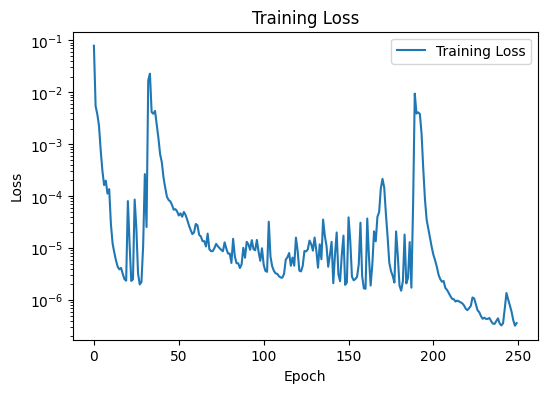

Mean Squared Error on Evaluation: 0.0043
Average Position Error: 9.09 pixels
Average Position Accuracy (±1 pixel): 0.00%


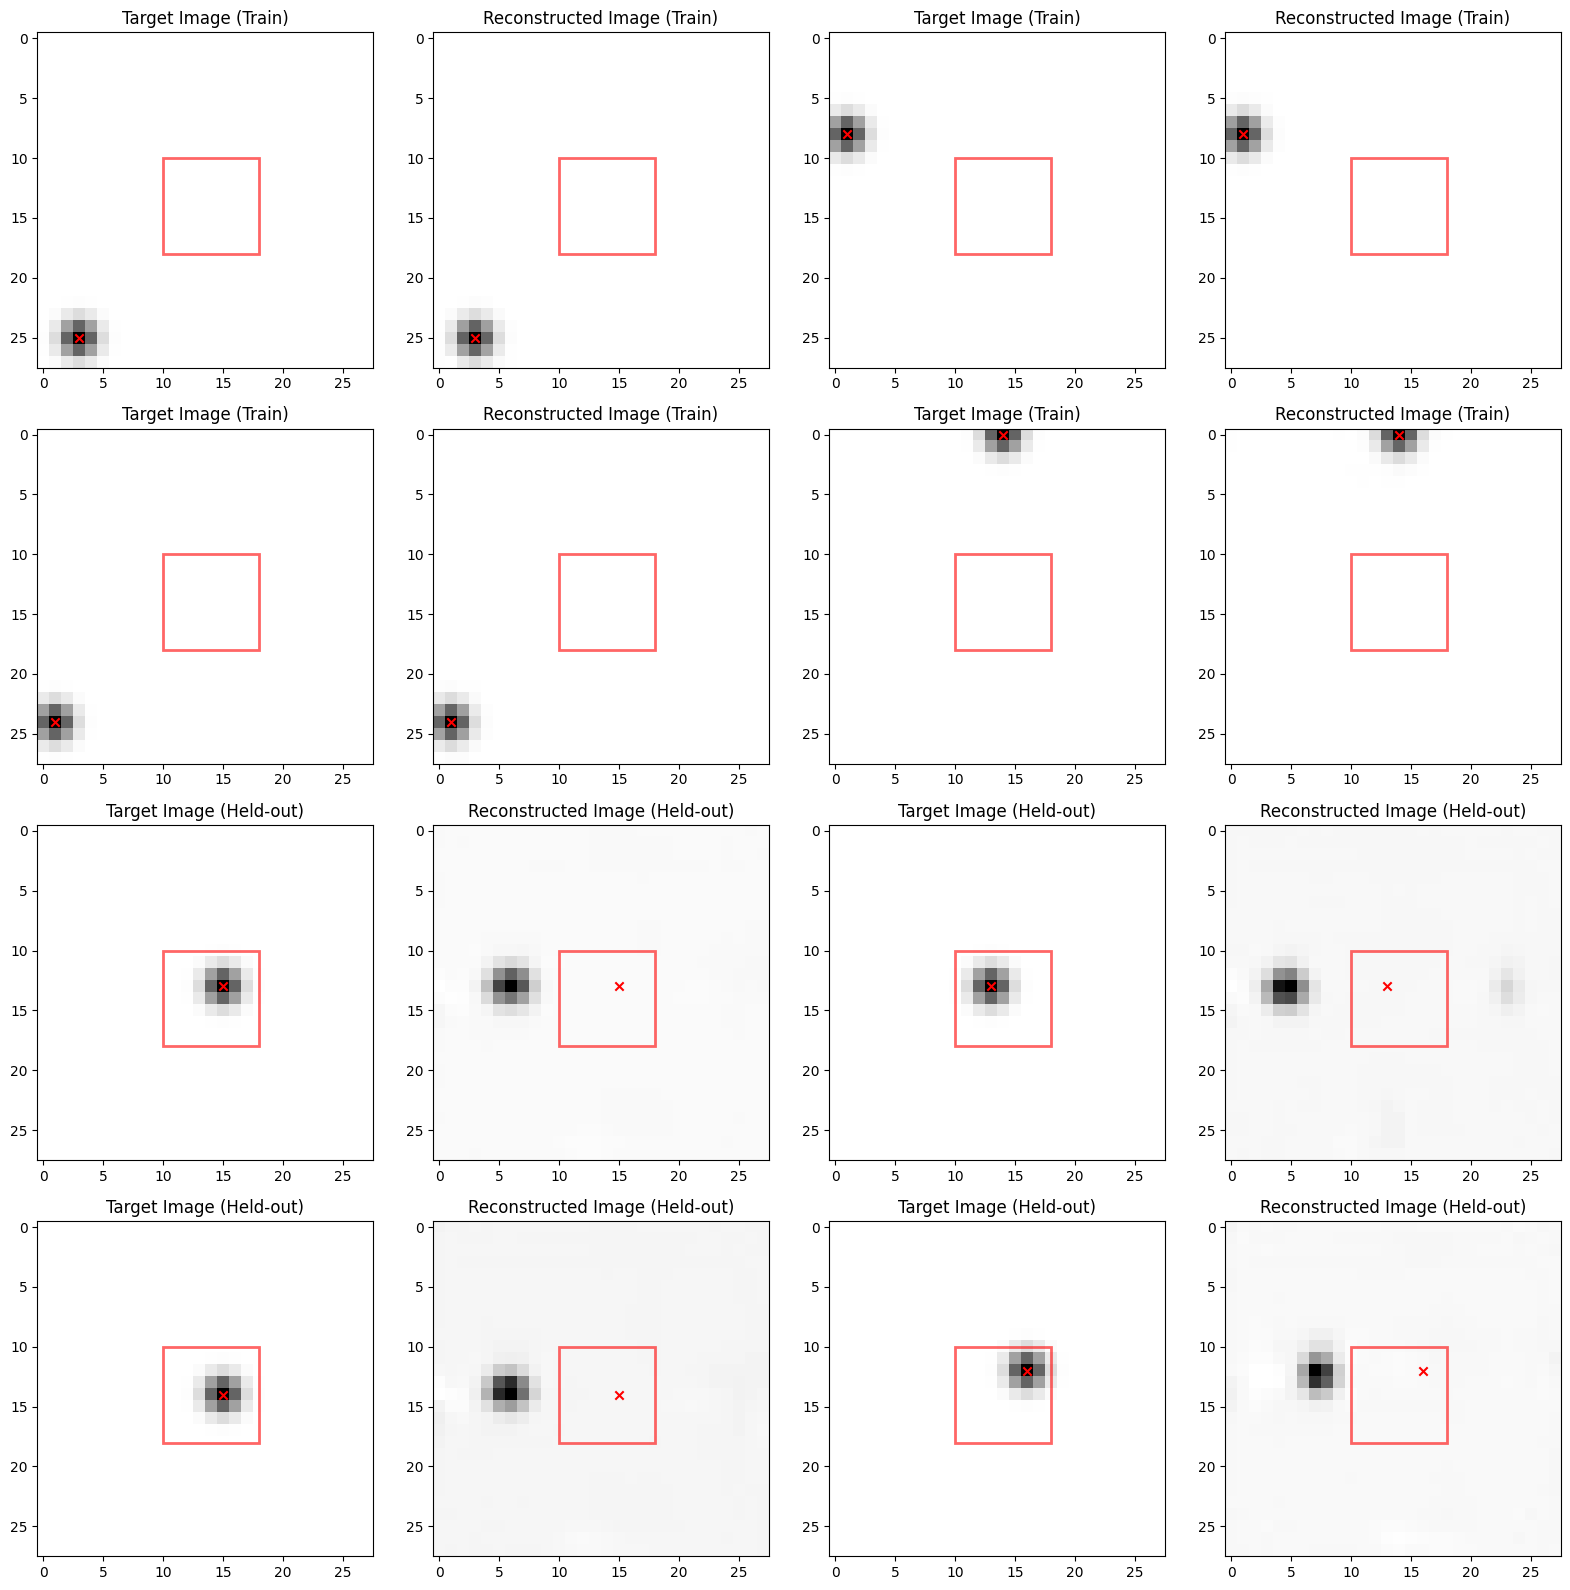

In [6]:
# Hyperparameters
input_size = 56
hidden_size = 256  # Adjusted for manageable computation
n_hidden_layers = 10
batch_size = 32
num_epochs = 250
learning_rate = 1e-3
width_multiplier = 1

# Dataset and DataLoader for Training (excluding center 6x6 region)
train_dataset = GaussianBumpDatasetSquare(num_samples=1000, grid_size=28, holdout_center=True, heldout_range=[10,18], bump_encoding_width_multiplier=width_multiplier)
# train_dataset = GaussianBumpDatasetCross(num_samples=1000, grid_size=28, holdout_cross=True, heldout_range=[10,18]) # cross held-out
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Dataset and DataLoader for Evaluation (only center 6x6 region)
eval_dataset = GaussianBumpDatasetSquare(num_samples=100, grid_size=28, only_holdout=True, heldout_range=[12,16], bump_encoding_width_multiplier=width_multiplier)
# eval_dataset = GaussianBumpDatasetCross(num_samples=100, grid_size=28, only_holdout=True, heldout_range=[10,18]) # cross held-out
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

# Model Initialization
decoder = CNNDecoderWithActivations(
    input_size=input_size,
    hidden_size=hidden_size,
    n_hidden_layers=n_hidden_layers
).to(device)

# Train the model
train_model(decoder, train_dataloader, num_epochs=num_epochs, learning_rate=learning_rate)

# Evaluate the model and visualize some samples on held-out data
evaluate_model(decoder, train_dataloader, eval_dataloader)

In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import os

def analyze_2d_reconstruction_error(model, heldout_range=[6,22], grid_size=28, device='cuda', resolution=50, sigma=1.0, bump_encoding_width_multiplier=1.0):
    """
    Analyze reconstruction error across 2D space, highlighting the OOD region.
    
    Args:
        model: The trained model
        grid_size: Size of the output grid (default: 28)
        device: Computing device
        resolution: Number of points to evaluate in each dimension
        sigma: Width of the Gaussian bumps
        bump_encoding_width_multiplier: Multiplier for the width of input Gaussian bumps
    """
    model.eval()
    
    # Create evaluation grid
    x = np.linspace(0, grid_size-1, resolution)
    y = np.linspace(0, grid_size-1, resolution)
    X, Y = np.meshgrid(x, y)
    
    # Define OOD region
    ood_min = heldout_range[0]
    ood_max = heldout_range[1]
    
    # Initialize error arrays
    mse_errors = np.zeros((resolution, resolution))
    ssim_errors = np.zeros((resolution, resolution))
    
    with torch.no_grad():
        for i in range(resolution):
            for j in range(resolution):
                # Current position
                pos_x, pos_y = x[i], y[j]
                
                # Generate input Gaussian bumps
                gaussian_x = np.exp(-((np.arange(grid_size) - pos_x) ** 2) /
                                (2 * bump_encoding_width_multiplier * sigma ** 2))
                gaussian_y = np.exp(-((np.arange(grid_size) - pos_y) ** 2) /
                                (2 * bump_encoding_width_multiplier * sigma ** 2))
                input_data = np.concatenate((gaussian_x, gaussian_y))
                # pos_encoding = positional_encoding(x[i], y[i])
                
                # Generate target Gaussian image
                xv, yv = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
                target = 1.0 - np.exp(-((xv - pos_x) ** 2 + (yv - pos_y) ** 2) / (2 * sigma ** 2))
                
                # Convert to tensors
                input_tensor = torch.tensor(input_data, dtype=torch.float32, device=device).unsqueeze(0)
                target_tensor = torch.tensor(target, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
                
                # Generate prediction
                prediction = model(input_tensor)
                
                # Compute errors
                mse = F.mse_loss(prediction, target_tensor).item()
                mse_errors[j, i] = mse
                
                # Compute SSIM
                pred_np = prediction.cpu().squeeze().numpy()
                target_np = target_tensor.cpu().squeeze().numpy()
                ssim_value = ssim(target_np, pred_np, data_range=1.0)
                ssim_errors[j, i] = 1 - ssim_value
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    
    # Plot MSE error
    im1 = ax1.contourf(X, Y, mse_errors, levels=20, cmap='viridis')
    ax1.add_patch(plt.Rectangle((ood_min, ood_min), ood_max-ood_min, ood_max-ood_min,
                               fill=False, color='red', linestyle='--', linewidth=2))
    ax1.set_title(f'MSE Error (multiplier={bump_encoding_width_multiplier})')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    plt.colorbar(im1, ax=ax1)
    
    # Plot SSIM error
    im2 = ax2.contourf(X, Y, ssim_errors, levels=20, cmap='viridis')
    ax2.add_patch(plt.Rectangle((ood_min, ood_min), ood_max-ood_min, ood_max-ood_min,
                               fill=False, color='red', linestyle='--', linewidth=2))
    ax2.set_title(f'1 - SSIM (multiplier={bump_encoding_width_multiplier})')
    ax2.set_xlabel('X Position')
    ax2.set_ylabel('Y Position')
    plt.colorbar(im2, ax=ax2)
    
    # Add text with statistics
    in_dist_mask = ((X < ood_min) | (X > ood_max)) | ((Y < ood_min) | (Y > ood_max))
    ood_mask = ~in_dist_mask
    
    stats_text = f"In-Distribution Stats:\n"
    stats_text += f"MSE: {np.mean(mse_errors[in_dist_mask]):.6f} ± {np.std(mse_errors[in_dist_mask]):.6f}\n"
    stats_text += f"SSIM Error: {np.mean(ssim_errors[in_dist_mask]):.6f} ± {np.std(ssim_errors[in_dist_mask]):.6f}\n\n"
    stats_text += f"OOD Stats:\n"
    stats_text += f"MSE: {np.mean(mse_errors[ood_mask]):.6f} ± {np.std(mse_errors[ood_mask]):.6f}\n"
    stats_text += f"SSIM Error: {np.mean(ssim_errors[ood_mask]):.6f} ± {np.std(ssim_errors[ood_mask]):.6f}"
    
    plt.figtext(1.02, 0.5, stats_text, fontsize=10, ha='left', va='center')
    
    plt.tight_layout()
    plt.show()
    # Print summary statistics
    print(f"\nError Statistics for multiplier {bump_encoding_width_multiplier}:")
    print("In Distribution:")
    print(f"Mean MSE: {np.mean(mse_errors[in_dist_mask]):.6f}")
    print(f"Std MSE: {np.std(mse_errors[in_dist_mask]):.6f}")
    print(f"Mean SSIM Error: {np.mean(ssim_errors[in_dist_mask]):.6f}")
    print(f"Std SSIM Error: {np.std(ssim_errors[in_dist_mask]):.6f}")
    
    print("\nOut of Distribution:")
    print(f"Mean MSE: {np.mean(mse_errors[ood_mask]):.6f}")
    print(f"Std MSE: {np.std(mse_errors[ood_mask]):.6f}")
    print(f"Mean SSIM Error: {np.mean(ssim_errors[ood_mask]):.6f}")
    print(f"Std SSIM Error: {np.std(ssim_errors[ood_mask]):.6f}")
    
    return X, Y, mse_errors, ssim_errors

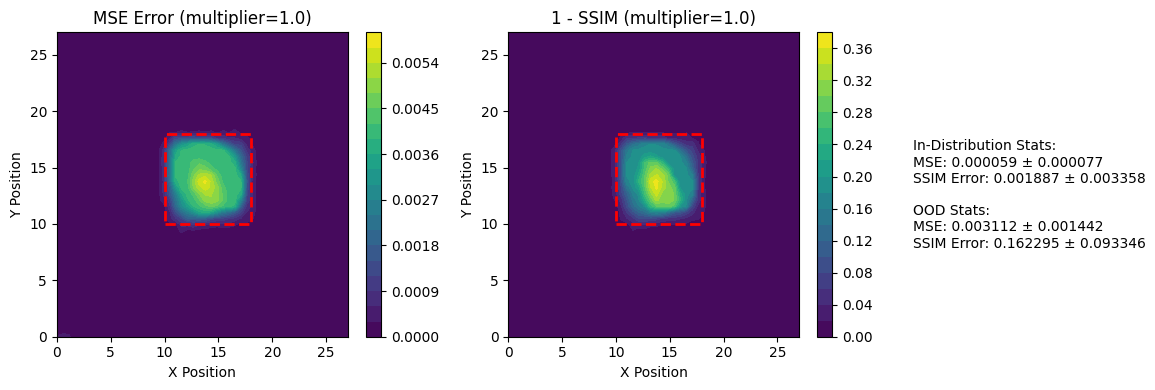


Error Statistics for multiplier 1.0:
In Distribution:
Mean MSE: 0.000059
Std MSE: 0.000077
Mean SSIM Error: 0.001887
Std SSIM Error: 0.003358

Out of Distribution:
Mean MSE: 0.003112
Std MSE: 0.001442
Mean SSIM Error: 0.162295
Std SSIM Error: 0.093346


In [8]:
X, Y, mse_errors, ssim_errors = analyze_2d_reconstruction_error(decoder, heldout_range=[10,18])

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Script to sample labels from different OOD regions and generate images
def generate_ood_samples(model, sample_range=[11, 17], grid_size=28, sigma=1.0):
    model.eval()
    num_samples = 10

    plt.figure(figsize=(20, 8))
    with torch.no_grad():
        # First row: Sample from vertical rectangle (x within 11 to 17, y outside 11 to 17)
        for i in range(num_samples):
            while True:
                x = np.random.randint(sample_range[0], sample_range[1])
                y = np.random.choice(list(range(sample_range[0])) + list(range(sample_range[1], grid_size)))
                if not (sample_range[0] <= y < sample_range[1]):
                    break

            gaussian_x = np.exp(-((np.arange(grid_size) - x) ** 2) / (2 * sigma ** 2))
            gaussian_y = np.exp(-((np.arange(grid_size) - y) ** 2) / (2 * sigma ** 2))
            latent_vector = np.concatenate((gaussian_x, gaussian_y))
            # latent_vector = np.array([x, y])
            latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).to(device).unsqueeze(0)

            output_image = model(latent_tensor).cpu().squeeze().numpy()

            plt.subplot(3, 10, i + 1)
            plt.title("Vertical")
            plt.gca().add_patch(plt.Rectangle(
                (sample_range[0], 0), sample_range[1]-sample_range[0], 28, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))
            plt.gca().add_patch(plt.Rectangle(
                (0, sample_range[0]), 28, sample_range[1]-sample_range[0], linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))
            # plt.gca().add_patch(plt.Rectangle(
            #     (sample_range[0], 0), sample_range[1]-sample_range[0], sample_range[0], linewidth=2, edgecolor='red', facecolor='red', alpha=0.1))
            # plt.gca().add_patch(plt.Rectangle(
            #     (sample_range[0], sample_range[1]), sample_range[1]-sample_range[0], sample_range[0], linewidth=2, edgecolor='red', facecolor='red', alpha=0.1))
            plt.imshow(output_image, cmap='gray')
            predicted_center = np.unravel_index(np.argmax(1.0 - output_image), output_image.shape)
            plt.scatter([predicted_center[1]], [predicted_center[0]], color='blue', marker='o')
            plt.scatter([x], [y], color='red', marker='x')

        # Second row: Sample from horizontal rectangle (y within 11 to 17, x outside 11 to 17)
        for i in range(num_samples):
            while True:
                y = np.random.randint(sample_range[0], sample_range[1])
                x = np.random.choice(list(range(sample_range[0])) + list(range(sample_range[1], grid_size)))
                if not (sample_range[0] <= x < sample_range[1]):
                    break

            gaussian_x = np.exp(-((np.arange(grid_size) - x) ** 2) / (2 * sigma ** 2))
            gaussian_y = np.exp(-((np.arange(grid_size) - y) ** 2) / (2 * sigma ** 2))
            latent_vector = np.concatenate((gaussian_x, gaussian_y))
            # latent_vector = np.array([x, y])

            latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).to(device).unsqueeze(0)

            output_image = model(latent_tensor).cpu().squeeze().numpy()

            plt.subplot(3, 10, 10 + i + 1)
            plt.title("Horizontal")
            plt.gca().add_patch(plt.Rectangle(
                (sample_range[0], 0), sample_range[1]-sample_range[0], 28, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))
            plt.gca().add_patch(plt.Rectangle(
                (0, sample_range[0]), 28, sample_range[1]-sample_range[0], linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))
            # plt.gca().add_patch(plt.Rectangle(
            #     (0, sample_range[0]), sample_range[0], sample_range[1]-sample_range[0], linewidth=2, edgecolor='red', facecolor='red', alpha=0.1))
            # plt.gca().add_patch(plt.Rectangle(
            #     (sample_range[1], sample_range[0]), sample_range[0], sample_range[1]-sample_range[0], linewidth=2, edgecolor='red', facecolor='red', alpha=0.1))
            plt.imshow(output_image, cmap='gray')
            predicted_center = np.unravel_index(np.argmax(1.0 - output_image), output_image.shape)
            plt.scatter([predicted_center[1]], [predicted_center[0]], color='blue', marker='o')
            plt.scatter([x], [y], color='red', marker='x')

        # Third row: Sample from intersection (x within 11 to 17, y within 11 to 17)
        for i in range(num_samples):
            x = np.random.randint(sample_range[0], sample_range[1])
            y = np.random.randint(sample_range[0], sample_range[1])

            gaussian_x = np.exp(-((np.arange(grid_size) - x) ** 2) / (2 * sigma ** 2))
            gaussian_y = np.exp(-((np.arange(grid_size) - y) ** 2) / (2 * sigma ** 2))
            latent_vector = np.concatenate((gaussian_x, gaussian_y))
            # latent_vector = np.array([x, y])

            latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).to(device).unsqueeze(0)

            output_image = model(latent_tensor).cpu().squeeze().numpy()

            plt.subplot(3, 10, 20 + i + 1)
            plt.title("Intersection")
            plt.gca().add_patch(plt.Rectangle(
                (sample_range[0], 0), sample_range[1]-sample_range[0], 28, linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))
            plt.gca().add_patch(plt.Rectangle(
                (0, sample_range[0]), 28, sample_range[1]-sample_range[0], linewidth=2, edgecolor='red', facecolor='none', alpha=0.6))
            plt.gca().add_patch(plt.Rectangle(
                (sample_range[0], sample_range[0]), sample_range[1]-sample_range[0], sample_range[1]-sample_range[0], linewidth=2, edgecolor='red', facecolor='red', alpha=0.1))
            plt.imshow(output_image, cmap='gray')
            predicted_center = np.unravel_index(np.argmax(1.0 - output_image), output_image.shape)
            plt.scatter([predicted_center[1]], [predicted_center[0]], color='blue', marker='o')
            plt.scatter([x], [y], color='red', marker='x')

    plt.tight_layout()
    plt.show()

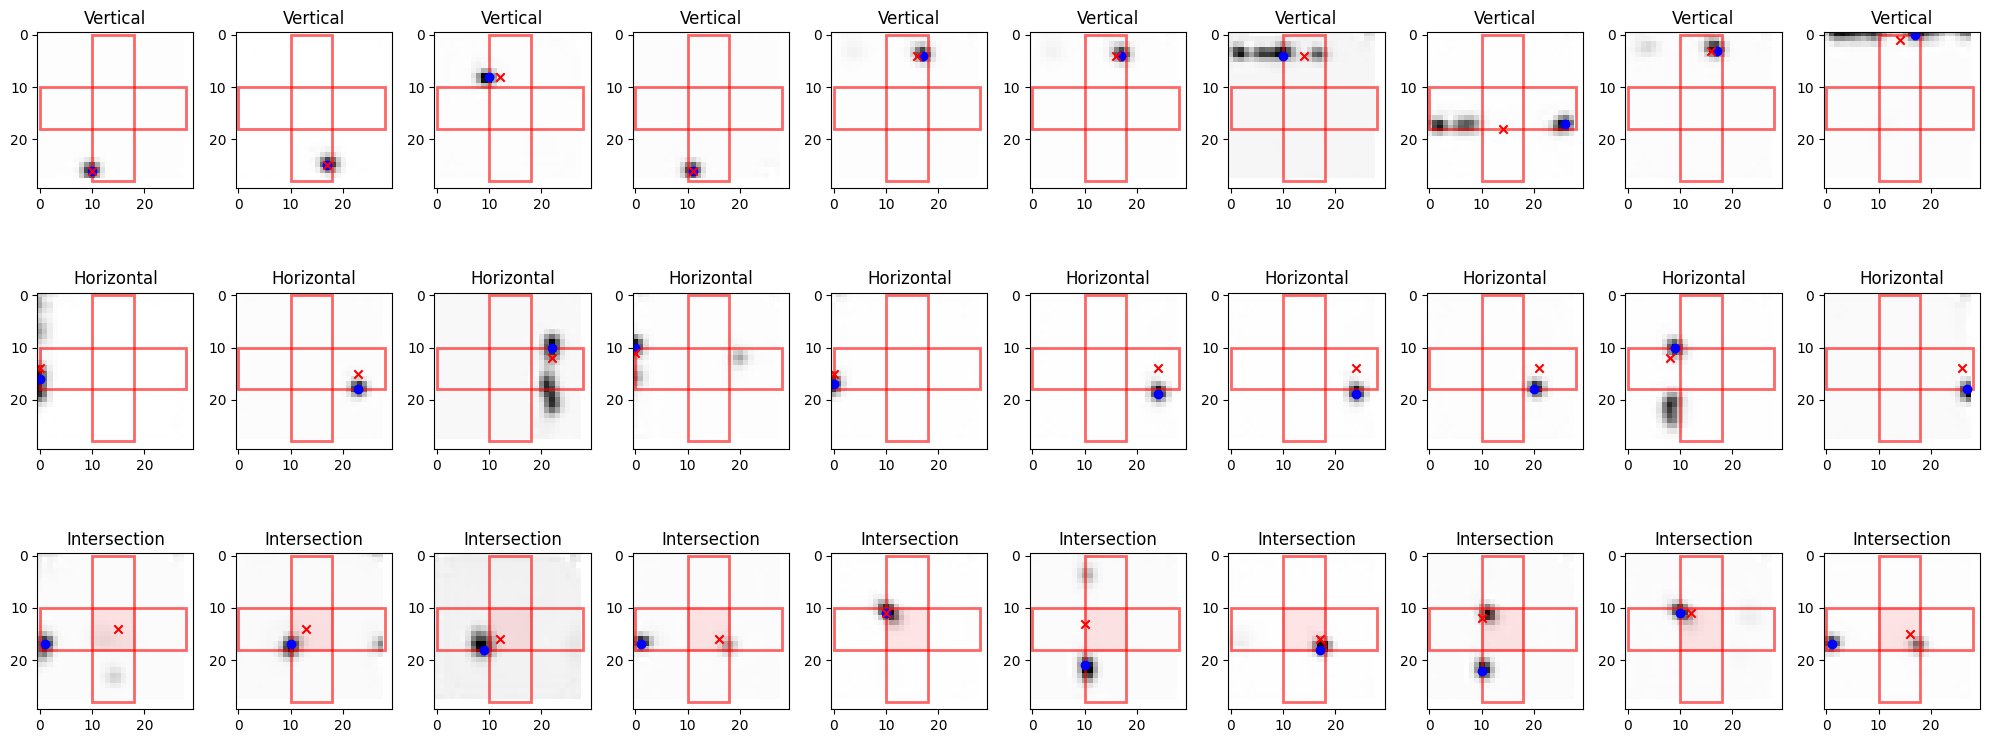

In [7]:
generate_ood_samples(decoder, sample_range=[10,18])

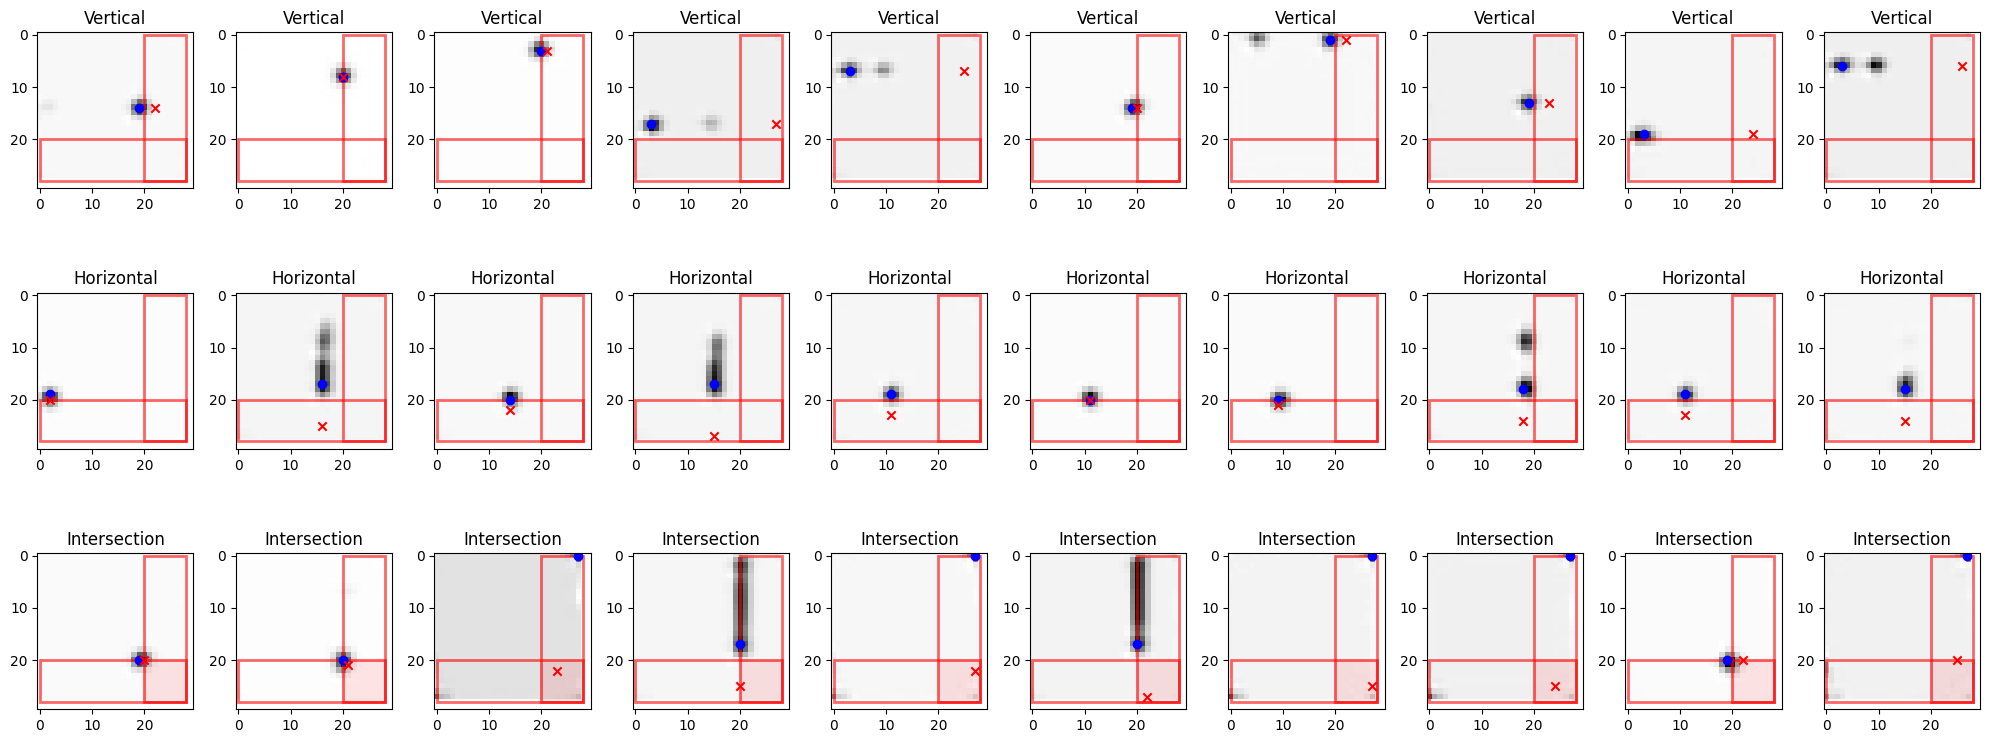

In [5]:
generate_ood_samples(decoder, sample_range=[20,28])

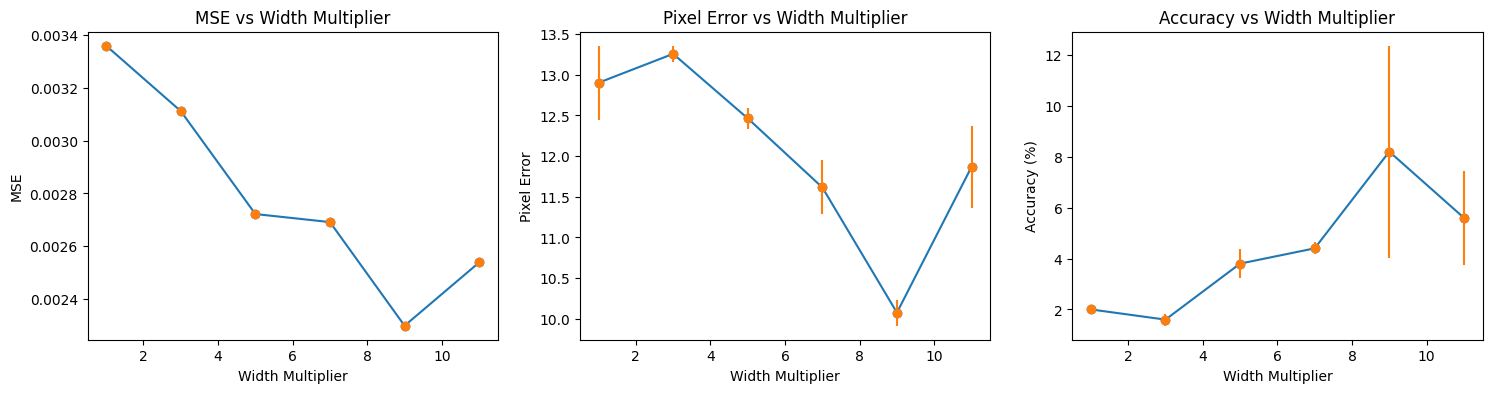

In [3]:
widths_multipliers = [1, 3, 5, 7, 9, 11]
# MSEs = [0.0033,0.0027,0.0027,0.0028,0.0027,0.0023]
# pixel_errors = [13.69,11.97,12.88,12.80,11,10.21]
# accuracies = [3,6,6,4,2,5]
import pickle
import numpy as np
import matplotlib.pyplot as plt

MSEs = []
MSE_var = []
pixel_errors = []
pixel_errors_var = []
accuracies = []
accuracies_var = []

for width in widths_multipliers:
    with open(f'../data/11_14_multiplier_exp/multiplier_{width}.pkl', 'rb') as f:
        results = pickle.load(f)
        MSEs.append(np.mean(results['mse']))
        MSE_var.append(np.var(results['mse']))
        pixel_errors.append(np.mean(results['avg_error']))
        pixel_errors_var.append(np.var(results['avg_error']))
        accuracies.append(np.mean(results['avg_accuracy']))
        accuracies_var.append(np.var(results['avg_accuracy']))


fig, axs = plt.subplots(1, 3, figsize=(18, 4))
axs[0].plot(widths_multipliers, MSEs, marker='o')
axs[0].errorbar(widths_multipliers, MSEs, yerr=MSE_var, fmt='o')
axs[0].set_xlabel('Width Multiplier')
axs[0].set_ylabel('MSE')
axs[0].set_title('MSE vs Width Multiplier')

axs[1].plot(widths_multipliers, pixel_errors, marker='o')
axs[1].errorbar(widths_multipliers, pixel_errors, yerr=pixel_errors_var, fmt='o')
axs[1].set_xlabel('Width Multiplier')
axs[1].set_ylabel('Pixel Error')
axs[1].set_title('Pixel Error vs Width Multiplier')

axs[2].plot(widths_multipliers, accuracies, marker='o')
axs[2].errorbar(widths_multipliers, accuracies, yerr=accuracies_var, fmt='o')
axs[2].set_xlabel('Width Multiplier')
axs[2].set_ylabel('Accuracy (%)')
axs[2].set_title('Accuracy vs Width Multiplier')

plt.show()

Mean Squared Error on Evaluation: 0.0043
Average Position Error: 15.14 pixels
Average Position Accuracy (±1 pixel): 0.00%


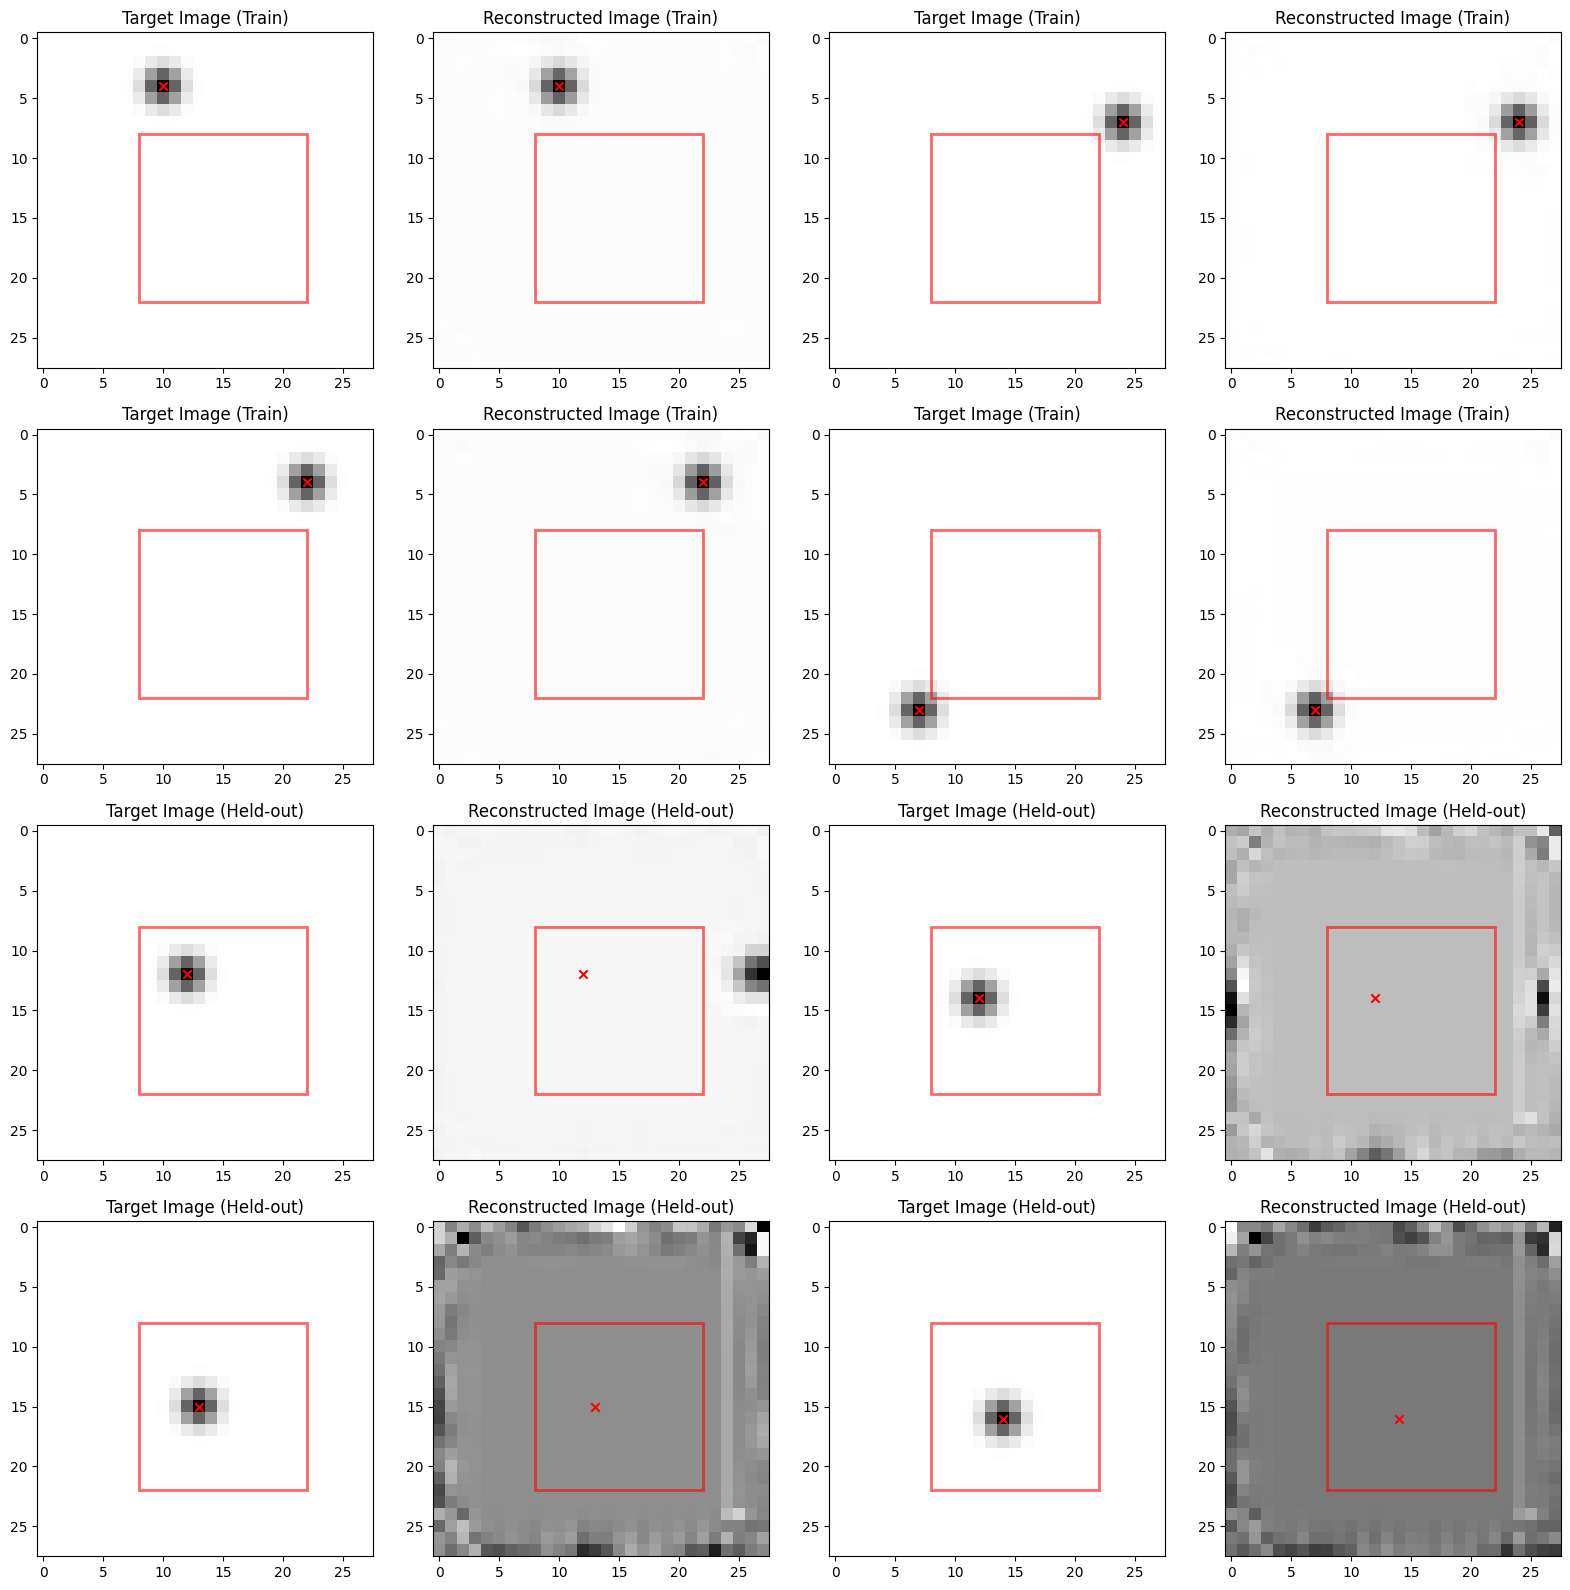

In [10]:
evaluate_model(decoder, train_dataloader, eval_dataloader, heldout_range=[8,22])

In [12]:
# save model 
torch.save(decoder.state_dict(), './cnn_decoder.pth')

Mean Squared Error on Evaluation: 0.0000


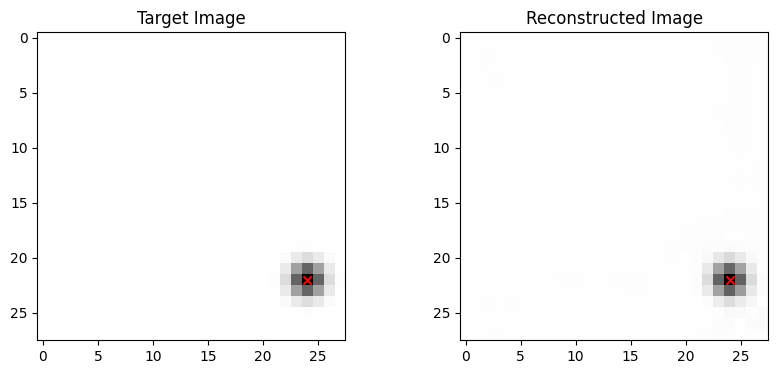

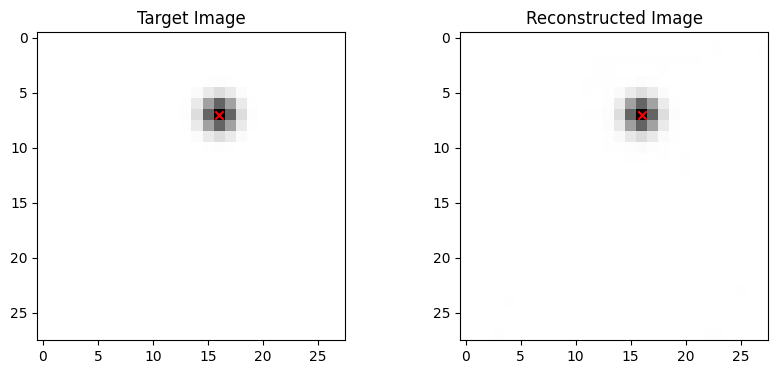

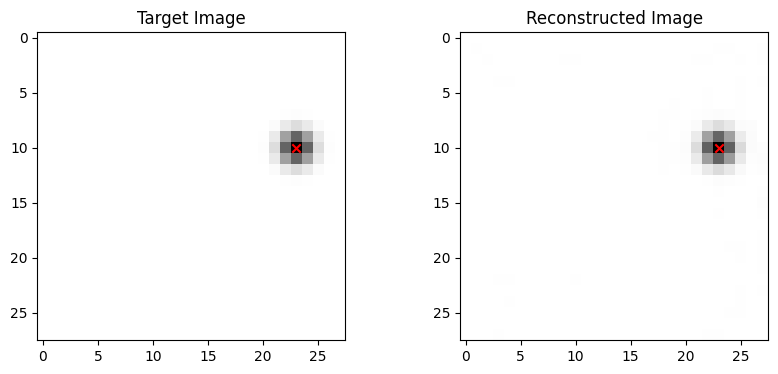

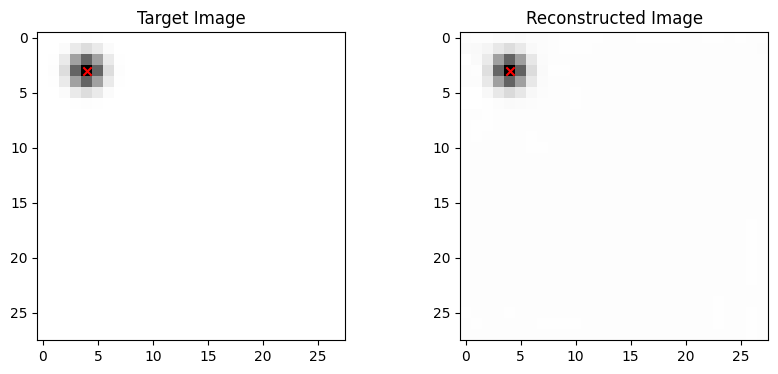

In [13]:
def evaluate_model(model, dataloader):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Ensure the model is on the same device as during training

    mse_loss = 0.0
    criterion = nn.MSELoss()
    num_samples = 4
    sampled_inputs, sampled_targets, sampled_outputs = [], [], []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
            outputs = model(inputs)
            mse_loss += criterion(outputs, targets).item() * inputs.size(0)

            if batch_idx < num_samples:
                sampled_inputs.append(inputs.cpu())  # Store on CPU for visualization
                sampled_targets.append(targets.cpu())  # Store on CPU for visualization
                sampled_outputs.append(outputs.cpu())  # Store on CPU for visualization

    mse_loss /= len(dataloader.dataset)
    print(f"Mean Squared Error on Evaluation: {mse_loss:.4f}")

    # Plot sampled images
    for i in range(num_samples):
        input_coords = sampled_inputs[i][0].numpy()
        # print(input_coords)
        target_image = sampled_targets[i][0].squeeze().numpy()
        output_image = sampled_outputs[i][0].squeeze().numpy()

        # x, y = input_coords[0], input_coords[1]
        x, y = np.argmax(input_coords[:28]), np.argmax(input_coords[28:])

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title("Target Image")
        plt.imshow(target_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.subplot(1, 2, 2)
        plt.title("Reconstructed Image")
        plt.imshow(output_image, cmap='gray')
        plt.scatter([x], [y], color='red', marker='x')
        plt.show()

# Evaluate the model and visualize some samples
evaluate_model(decoder, train_dataloader)

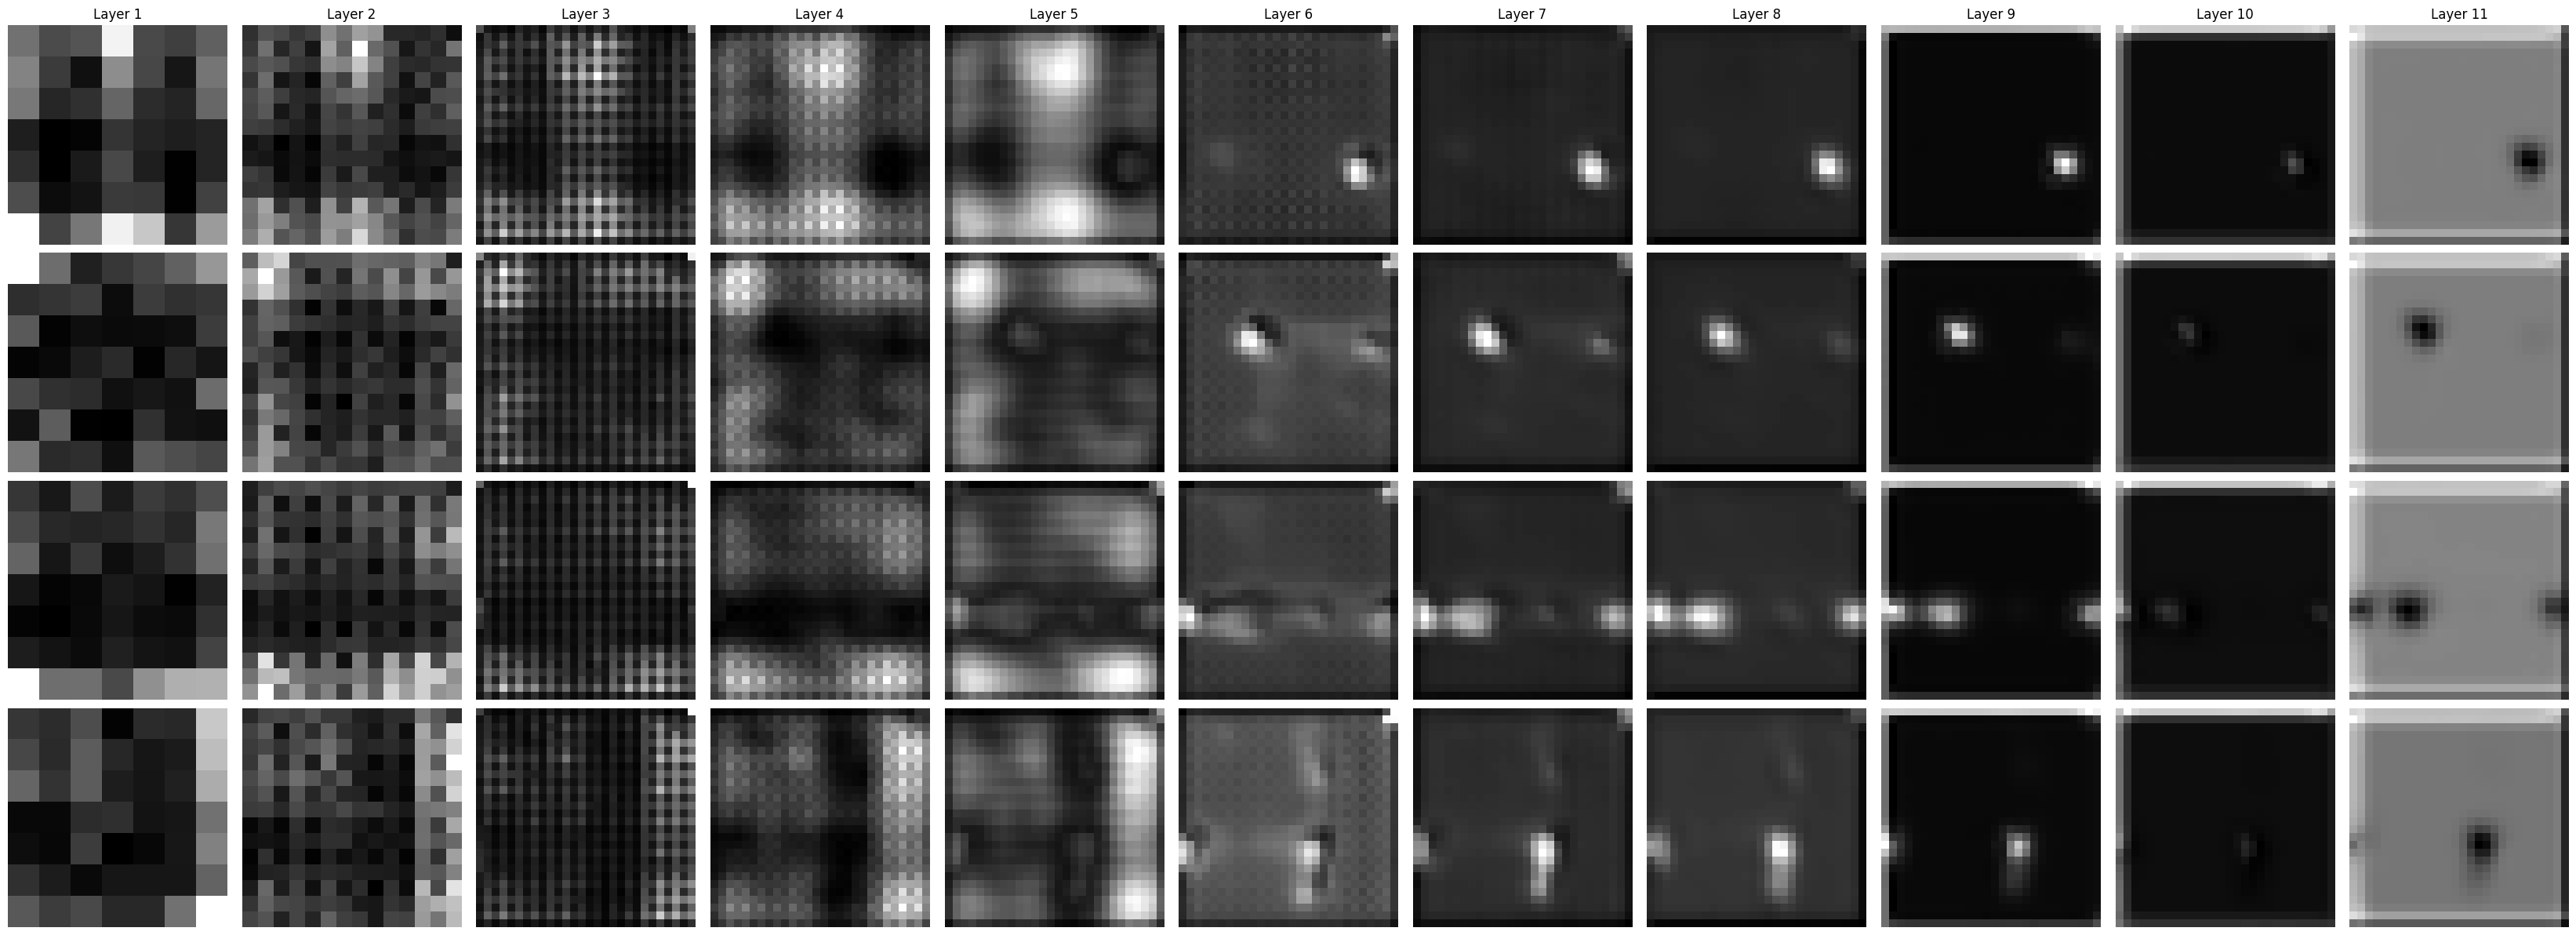

In [8]:
def visualize_layers(model, train_dataloader, device=torch.device('cuda')):
    model.eval()
    criterion = nn.MSELoss()
    num_samples = 4  # Number of samples to visualize
    sampled_inputs, sampled_targets, sampled_outputs = [], [], []
    sampled_activations = []

    with torch.no_grad():
        # Collect samples from training data
        for batch_idx, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # Collect activations
            activations = [activation.clone().detach().cpu() for activation in model.activations]
            if len(sampled_inputs) < num_samples:
                sampled_inputs.append(inputs.cpu())
                sampled_targets.append(targets.cpu())
                sampled_outputs.append(outputs.cpu())
                # Store activations for the first sample in the batch
                sampled_activation_per_sample = [activation[0] for activation in activations]  # List of tensors
                sampled_activations.append(sampled_activation_per_sample)
            else:
                break  # We have collected enough samples

    # Now we have num_samples samples and their activations
    num_layers = len(sampled_activations[0])  # Number of activations collected

    # Create a grid of plots
    fig, axes = plt.subplots(num_samples, num_layers, figsize=(num_layers * 3, num_samples * 3))

    for i in range(num_samples):
        activations = sampled_activations[i]
        for j in range(num_layers):
            activation = activations[j]  # Shape: (channels, height, width)
            # Compute mean over channels to get a single image
            activation_image = activation.mean(dim=0).numpy()
            # Normalize the activation image for better visualization
            activation_image -= activation_image.min()
            activation_image /= activation_image.max() + 1e-8  # Avoid division by zero
            ax = axes[i, j]
            ax.imshow(activation_image, cmap='gray')
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Layer {j+1}')
    plt.tight_layout()
    plt.show()

visualize_layers(decoder, eval_dataloader)

# Load model

In [15]:
# Hyperparameters
input_size = 56
hidden_size = 256  # Adjusted for manageable computation
n_hidden_layers = 10
batch_size = 32
num_epochs = 100
learning_rate = 1e-4

# Dataset and DataLoader for Training (excluding center 6x6 region)
train_dataset = GaussianBumpDataset(num_samples=1000, grid_size=28, holdout_center=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Dataset and DataLoader for Evaluation (only center 6x6 region)
eval_dataset = GaussianBumpDataset(num_samples=100, grid_size=28, only_holdout=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

# Model Initialization
decoder = CNNDecoderWithActivations(
    input_size=input_size,
    hidden_size=hidden_size,
    n_hidden_layers=n_hidden_layers
).to(device)

decoder.load_state_dict(torch.load('./cnn_decoder.pth'))

/tmp/ipykernel_2395898/1886091018.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load('./cnn_decoder.pth'))


RuntimeError: Error(s) in loading state_dict for CNNDecoderWithActivations:
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([56, 64, 7, 7]) from checkpoint, the shape in current model is torch.Size([56, 256, 7, 7]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.2.weight: copying a param with shape torch.Size([64, 64, 4, 4]) from checkpoint, the shape in current model is torch.Size([256, 256, 4, 4]).
	size mismatch for decoder.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.4.weight: copying a param with shape torch.Size([64, 64, 4, 4]) from checkpoint, the shape in current model is torch.Size([256, 256, 4, 4]).
	size mismatch for decoder.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.6.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for decoder.6.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.8.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for decoder.8.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.10.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for decoder.10.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.12.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for decoder.12.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.14.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for decoder.14.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.16.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for decoder.16.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.18.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for decoder.18.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.20.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for decoder.20.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.22.weight: copying a param with shape torch.Size([64, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 1, 3, 3]).

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:05<00:00,  5.46s/it]


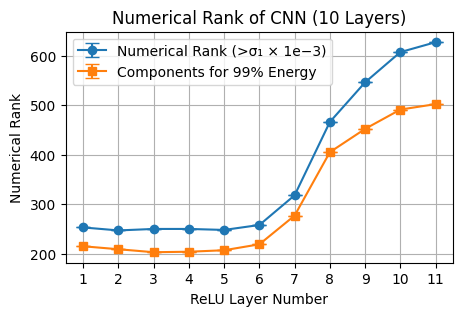

In [16]:
from tqdm import tqdm
def rank_vis(model, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    # Ensure the model is in evaluation mode
    model.eval()

    # Create the test dataset and DataLoader
    test_dataset = GaussianBumpDataset(num_samples=1500, grid_size=28)
    test_loader = DataLoader(test_dataset, batch_size=1500, shuffle=False)

    # Initialize lists to store ranks for each batch
    effective_ranks_per_layer = []
    ranks_99_per_layer = []
    layer_numbers = None

    # Subsample limit to optimize computation
    max_samples = 1500  # Adjust as needed based on available memory

    for inputs, _ in tqdm(test_loader):
        inputs = inputs.to(device)
        # Perform forward pass and collect activations
        outputs = model(inputs)
        activations = model.activations

        if layer_numbers is None:
            num_layers = len(activations)
            layer_numbers = list(range(1, num_layers + 1))

        batch_effective_ranks = []
        batch_ranks_99 = []

        for activation in activations:
            # Move activation to CPU and detach
            activation = activation.detach().cpu()

            # Reshape activations to (n_samples, n_features)
            batch_size_, channels, height, width = activation.shape
            activation = activation.view(batch_size_,-1)  # (batch_size, channels, height*width)
            # print('activation shape: ', activation.shape)
            # activation = activation.permute(0, 2, 1)  # (batch_size, height*width, channels)
            # activation = activation.reshape(-1, channels)  # (batch_size * height * width, channels)

            # Subsample activations if necessary
            idx = torch.randperm(activation.shape[1])[:max_samples]
            activation = activation[:, idx]

            # Center the activations
            activation_centered = activation - activation.mean(dim=0)

            # Convert to NumPy array
            activation_centered = activation_centered.numpy()

            # Compute the sample covariance matrix
            n_samples = activation_centered.shape[0]
            covariance_matrix = (1.0 / n_samples) * np.dot(activation_centered.T, activation_centered)

            # Compute eigenvalues of the covariance matrix
            eigenvalues = np.linalg.eigvalsh(covariance_matrix)
            eigenvalues = eigenvalues[::-1]  # Sort in descending order

            # Threshold σ = σ₁ × 1e−3
            sigma = eigenvalues[0] * 1e-3

            # Compute numerical rank
            effective_rank = np.sum(eigenvalues > sigma)
            batch_effective_ranks.append(effective_rank)

            # Compute components for 99% energy
            total_energy = np.sum(eigenvalues)
            cumulative_energy = np.cumsum(eigenvalues)
            num_components_99 = np.searchsorted(cumulative_energy, 0.99 * total_energy) + 1
            batch_ranks_99.append(num_components_99)
            # break

        effective_ranks_per_layer.append(batch_effective_ranks)
        ranks_99_per_layer.append(batch_ranks_99)

    # Convert lists to NumPy arrays
    effective_ranks_per_layer = np.array(effective_ranks_per_layer)  # (num_batches, num_layers)
    ranks_99_per_layer = np.array(ranks_99_per_layer)  # (num_batches, num_layers)

    # Calculate mean and standard deviation
    mean_effective_ranks = np.mean(effective_ranks_per_layer, axis=0)
    std_effective_ranks = np.std(effective_ranks_per_layer, axis=0)
    mean_ranks_99 = np.mean(ranks_99_per_layer, axis=0)
    std_ranks_99 = np.std(ranks_99_per_layer, axis=0)

    # Plotting the ranks with error bars
    plt.figure(figsize=(5, 3))
    plt.errorbar(layer_numbers, mean_effective_ranks, yerr=std_effective_ranks, fmt='-o', capsize=5,
                label='Numerical Rank (>σ₁ × 1e−3)')
    plt.errorbar(layer_numbers, mean_ranks_99, yerr=std_ranks_99, fmt='-s', capsize=5,
                label='Components for 99% Energy')
    plt.title('Numerical Rank of CNN (10 Layers)')
    plt.xlabel('ReLU Layer Number')
    plt.ylabel('Numerical Rank')
    plt.xticks(layer_numbers)
    plt.legend()
    plt.grid(True)
    plt.show()

rank_vis(decoder)